In [1]:
import matplotlib.pyplot as plt
import glob
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random
import tensorflow as tf
from keras import models, layers

In [2]:
audio_data_path = r'C:./set3'

In [3]:
#파라미터 설정
sr = 16000
n_mfcc = 116
n_mels = 104
# n_ttf = 
# hop_length
# 224 222 220 110 108 106 54  

In [4]:
trainset = []

In [5]:
label_mapping = {'belly_pain': 0, 'discomfort': 1, 'hungry': 2, 'tired': 3}

In [6]:
audio_path = glob.glob(os.path.join(audio_data_path, '*.wav'))
len(audio_path)

1522

In [7]:
mel_spec = []

for path in audio_path:
    audio, srate = librosa.load(path, sr=16000, duration=5.0)
    ml_spc = librosa.feature.melspectrogram(y=audio, sr=srate)
    mel_spec.append(ml_spc)

In [8]:
import collections

shapes = [arr.shape for arr in mel_spec]
shape_count = collections.Counter(shapes)
shape_count

Counter({(128, 157): 1341,
         (128, 134): 7,
         (128, 98): 6,
         (128, 107): 5,
         (128, 128): 5,
         (128, 151): 5,
         (128, 112): 5,
         (128, 118): 5,
         (128, 115): 4,
         (128, 117): 4,
         (128, 104): 4,
         (128, 109): 4,
         (128, 108): 4,
         (128, 144): 4,
         (128, 111): 3,
         (128, 119): 3,
         (128, 92): 3,
         (128, 101): 3,
         (128, 136): 3,
         (128, 103): 3,
         (128, 147): 3,
         (128, 42): 3,
         (128, 72): 3,
         (128, 84): 3,
         (128, 131): 3,
         (128, 93): 2,
         (128, 88): 2,
         (128, 140): 2,
         (128, 86): 2,
         (128, 155): 2,
         (128, 152): 2,
         (128, 132): 2,
         (128, 142): 2,
         (128, 130): 2,
         (128, 148): 2,
         (128, 126): 2,
         (128, 90): 2,
         (128, 91): 2,
         (128, 70): 2,
         (128, 41): 2,
         (128, 38): 2,
         (128, 133): 2,
  

In [9]:
import statistics
init_val = 0
temp = []

for key in shape_count.keys():
    h, w = key
    init_val += w
    temp.append(w)

avg_w = init_val // len(shape_count.keys())
median_w = statistics.median(temp)

print(avg_w, median_w)

100 104.5


In [10]:
mel_spec_re = []

for arr in mel_spec:
    h, w = arr.shape
    if w > avg_w:
        mel_spec_re.append(arr)

In [11]:
reshaped = []

for mspc in mel_spec_re:
    h, w = mspc.shape
    
    if w < h:
        left_width = (h - w) // 2
        pad_remainder = (h - w) % 2
        padded = np.pad(mspc, pad_width = ((0, 0), (left_width, left_width + pad_remainder)), mode = 'constant', constant_values=0)
        reshaped.append(padded)
    else:
        trunc_mspc = mspc[:, :h]
        reshaped.append(trunc_mspc)

In [12]:
shapes_re = [arr.shape for arr in reshaped]
shapes_count_re = collections.Counter(shapes_re)
shapes_count_re

Counter({(128, 128): 1456})

In [13]:
train = np.array(reshaped)
train.shape

(1456, 128, 128)

In [14]:
train_dim = train.reshape(train.shape + (1,))

In [15]:
# from sklearn.model_selection import train_test_split



# # 훈련 세트와 테스트 세트로 나누기 (예: 훈련 세트 80%, 테스트 세트 20%)
# X_train, X_test = train_test_split(train, test_size=0.2) #, random_state=1024

# # 결과 확인
# print(f"훈련 세트 크기: {X_train.shape}")
# print(f"테스트 세트 크기: {X_test.shape}")


In [16]:
# # X_train의 차원을 (샘플 수, 98, 98, 1)로 조정
# X_train_dim = X_train.reshape(X_train.shape + (1,))
# X_test_dim = X_test.reshape(X_test.shape + (1,))

In [17]:
# X_train_dim[0].shape

In [18]:
from tensorflow.keras.layers import LeakyReLU

def build_unet(input_shape):
    # Define the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # 인코더 Functional API 시작
    # [1]
    conv0 = layers.Conv2D(16, activation='relu', kernel_size = 3, padding='same')(inputs) # 104  52 26
    conv1 = layers.Conv2D(16, activation='relu', kernel_size = 3, padding='same')(conv0)  # Skip connection으로 Expanding path로 이어질 예정, 112
    conv2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1) # 52

# 104 52 26 13 26 52 1

    # [2]
    conv3 = layers.Conv2D(32, activation='relu', kernel_size = 3, padding='same')(conv2) # 52
    conv4 = layers.Conv2D(32, activation='relu', kernel_size = 3, padding='same')(conv3) # 
    conv5 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv4) #26


    # [3]
    conv6 = layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(conv5) # 26 
    conv7 = layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(conv6) # 
    conv8 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv7) #13


    # [4]
    conv9 = layers.Conv2D(128, activation='relu', kernel_size=3, padding='same')(conv8) # 13
    conv10 = layers.Conv2D(128, activation='relu', kernel_size=3, padding='same')(conv9) # 

    # Contracting path 끝

    # The output of the last encoder layer
    encoder_output = conv10


    # 디코더 functional api 시작
    # [6]
    trans01 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu')(conv10) # 26
    # crop01 = layers.Cropping2D(cropping=(4, 4))(conv4) 
    concat01 = layers.concatenate([trans01, conv7], axis=-1) # 44 & 52


    # [6]
    conv11 = layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(concat01) # 44 - 42
    conv12 = layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(conv11)  # 40


    trans02 = layers.Conv2DTranspose(32, kernel_size=2, strides=(2, 2), activation='relu')(conv12)
    # crop02 = layers.Cropping2D(cropping=(16, 16))(conv1) # 80 & 112
    concat02 = layers.concatenate([trans02, conv4], axis=-1)


    # [6]
    conv13 = layers.Conv2D(32, activation='relu', kernel_size=3, padding='same')(concat02) # 44 - 42
    conv14 = layers.Conv2D(32, activation='relu', kernel_size=3, padding='same')(conv13)  # 40


    trans03 = layers.Conv2DTranspose(16, kernel_size=2, strides=(2, 2), activation='relu')(conv14)
    # crop02 = layers.Cropping2D(cropping=(16, 16))(conv1) # 80 & 112
    concat03 = layers.concatenate([trans03, conv1], axis=-1)

    # [13]
    conv15 = layers.Conv2D(16, activation='relu', kernel_size=3, padding='same')(concat03) # 80 - 78 - 76
    conv16 = layers.Conv2D(16, activation='relu', kernel_size=3, padding='same')(conv15)
    # Expanding path 끝


    # Define the output layer for the U-Net
    outputs = layers.Conv2D(1, kernel_size=1)(conv16)


    # Full U-Net model
    unet_model = tf.keras.Model(inputs=inputs, outputs=outputs)


    # Return the full model and the encoder part
    encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)
    return unet_model, encoder_model

# Define your input shape based on your mel-spectrogram dimensions
input_shape = (128, 128, 1)  # Example shape
unet, encoder = build_unet(input_shape)

In [19]:
# input_shape = unet.layers[0].input_shape
# print("모델 입력층의 형태:", input_shape)

In [20]:
# print("X_train의 형태:", X_train_dim.shape)
# print("X_test의 형태:", X_test_dim.shape)

In [21]:
# X_test_dim[0].shape

In [22]:
# Compile and train your model
unet.compile(optimizer='adam', loss='mse')
history = unet.fit(train_dim, train_dim, batch_size=16, epochs=25)

Epoch 1/25
91/91 [==============================] - 7s 28ms/step - loss: 770.4802
Epoch 2/25
91/91 [==============================] - 3s 28ms/step - loss: 43.7663
Epoch 3/25
91/91 [==============================] - 2s 27ms/step - loss: 35.9000
Epoch 4/25
91/91 [==============================] - 2s 27ms/step - loss: 68.4556
Epoch 5/25
91/91 [==============================] - 2s 27ms/step - loss: 14.3701
Epoch 6/25
91/91 [==============================] - 2s 27ms/step - loss: 10.3567
Epoch 7/25
91/91 [==============================] - 2s 27ms/step - loss: 8.1515
Epoch 8/25
91/91 [==============================] - 2s 27ms/step - loss: 11.7296
Epoch 9/25
91/91 [==============================] - 2s 27ms/step - loss: 30.9492
Epoch 10/25
91/91 [==============================] - 2s 27ms/step - loss: 108.8796
Epoch 11/25
91/91 [==============================] - 2s 27ms/step - loss: 17.2471
Epoch 12/25
91/91 [==============================] - 2s 27ms/step - loss: 7.1859
Epoch 13/25
91/91 [======

In [23]:
# After training, save only the encoder model
# encoder.save('auto_encoder_model.h5')


C:\Users\Desk_Kang\AppData\Local\Temp\ipykernel_12344\3091234247.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


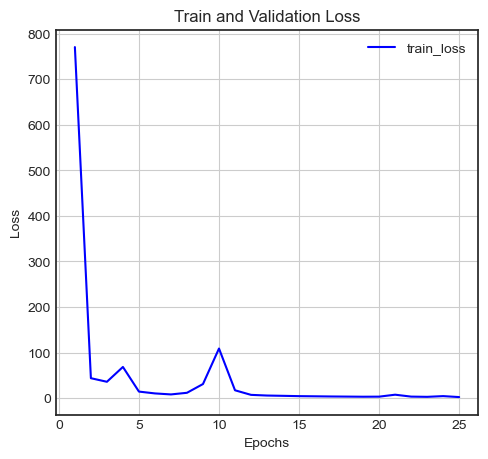

In [24]:
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


plt.show()